In [1]:
!pip install evaluate
!pip install -U transformers
!pip install accelerate -U

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 6.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.4/8.4 MB 64.9 MB/s eta 0:00:00:00:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 68.7 MB/s eta 0:00:00:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 330.1/330.1 kB 50.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 70.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 170.9/170.9 kB 31.9 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2023.1.0
    Uninstalling fsspec-2023.1.0:
      Successfully uninstalled fsspec-2023.1.0
  Attempting uninstall: huggingface-hub
    Found existing installation: huggingface-hub 0.12.0
    Uninstalling huggingface-hub-0.12.0:
      Successfully uninstalled huggingface-hub-0.12.0
  Attempting uninstall: tokenizers
    Found existing installation: tokenizers 0.12.1
    Uninstalling tokenizers-0.12.1:
      Successfully uninstalled

In [2]:
from datasets import Dataset
import requests
import pandas as pd
import io
from transformers import AutoModelForSequenceClassification
import re
import random
from transformers import AutoTokenizer
from sklearn.model_selection import train_test_split
from transformers import TrainingArguments, Trainer
import numpy as np
import evaluate
from transformers import pipeline
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix



tinyTest=False


url = 'https://raw.githubusercontent.com/bitext/customer-support-llm-chatbot-training-dataset/main/data/Bitext_Sample_Customer_Support_Training_Dataset_27K_responses-v11.csv'

response = requests.get(url)

if response.status_code == 200:

    csv_data = io.BytesIO(response.content)
    df = pd.read_csv(csv_data)
    print(df.head())  # Display the first few rows of the DataFrame
else:
    print("Failed to download the CSV file.")

print("Downloaded ",len(df),"rows")

df=df.drop('flags',axis=1)




   flags                                        instruction category  \
0      B   question about cancelling order {{Order Number}}    ORDER   
1    BQZ  i have a question about cancelling oorder {{Or...    ORDER   
2   BLQZ    i need help cancelling puchase {{Order Number}}    ORDER   
3     BL         I need to cancel purchase {{Order Number}}    ORDER   
4  BCELN  I cannot afford this order, cancel purchase {{...    ORDER   

         intent                                           response  
0  cancel_order  I've understood you have a question regarding ...  
1  cancel_order  I've been informed that you have a question ab...  
2  cancel_order  I can sense that you're seeking assistance wit...  
3  cancel_order  I understood that you need assistance with can...  
4  cancel_order  I'm sensitive to the fact that you're facing f...  
Downloaded  26872 rows


In [3]:
city_names = ["Aberdeen", "Abilene", "Akron", "Albany", "Albuquerque", "Alexandria", "Allentown", "Amarillo", "Anaheim", "Anchorage", "Ann Arbor", "Antioch", "Apple Valley", "Appleton", "Arlington", "Arvada", "Asheville", "Athens", "Atlanta", "Atlantic City", "Augusta", "Aurora", "Austin", "Bakersfield", "Baltimore", "Barnstable", "Baton Rouge", "Beaumont", "Bel Air", "Bellevue", "Berkeley", "Bethlehem", "Billings", "Birmingham", "Bloomington", "Boise", "Boise City", "Bonita Springs", "Boston", "Boulder", "Bradenton", "Bremerton", "Bridgeport", "Brighton", "Brownsville", "Bryan", "Buffalo", "Burbank", "Burlington", "Cambridge", "Canton", "Cape Coral", "Carrollton", "Cary", "Cathedral City", "Cedar Rapids", "Champaign", "Chandler", "Charleston", "Charlotte", "Chattanooga", "Chesapeake", "Chicago", "Chula Vista", "Cincinnati", "Clarke County", "Clarksville", "Clearwater", "Cleveland", "College Station", "Colorado Springs", "Columbia", "Columbus", "Concord", "Coral Springs", "Corona", "Corpus Christi", "Costa Mesa", "Dallas", "Daly City", "Danbury", "Davenport", "Davidson County", "Dayton", "Daytona Beach", "Deltona", "Denton", "Denver", "Des Moines", "Detroit", "Downey", "Duluth", "Durham", "El Monte", "El Paso", "Elizabeth", "Elk Grove", "Elkhart", "Erie", "Escondido", "Eugene", "Evansville", "Fairfield", "Fargo", "Fayetteville", "Fitchburg", "Flint", "Fontana", "Fort Collins", "Fort Lauderdale", "Fort Smith", "Fort Walton Beach", "Fort Wayne", "Fort Worth", "Frederick", "Fremont", "Fresno", "Fullerton", "Gainesville", "Garden Grove", "Garland", "Gastonia", "Gilbert", "Glendale", "Grand Prairie", "Grand Rapids", "Grayslake", "Green Bay", "GreenBay", "Greensboro", "Greenville", "Gulfport-Biloxi", "Hagerstown", "Hampton", "Harlingen", "Harrisburg", "Hartford", "Havre de Grace", "Hayward", "Hemet", "Henderson", "Hesperia", "Hialeah", "Hickory", "High Point", "Hollywood", "Honolulu", "Houma", "Houston", "Howell", "Huntington", "Huntington Beach", "Huntsville", "Independence", "Indianapolis", "Inglewood", "Irvine", "Irving", "Jackson", "Jacksonville", "Jefferson", "Jersey City", "Johnson City", "Joliet", "Kailua", "Kalamazoo", "Kaneohe", "Kansas City", "Kennewick", "Kenosha", "Killeen", "Kissimmee", "Knoxville", "Lacey", "Lafayette", "Lake Charles", "Lakeland", "Lakewood", "Lancaster", "Lansing", "Laredo", "Las Cruces", "Las Vegas", "Layton", "Leominster", "Lewisville", "Lexington", "Lincoln", "Little Rock", "Long Beach", "Lorain", "Los Angeles", "Louisville", "Lowell", "Lubbock", "Macon", "Madison", "Manchester", "Marina", "Marysville", "McAllen", "McHenry", "Medford", "Melbourne", "Memphis", "Merced", "Mesa", "Mesquite", "Miami", "Milwaukee", "Minneapolis", "Miramar", "Mission Viejo", "Mobile", "Modesto", "Monroe", "Monterey", "Montgomery", "Moreno Valley", "Murfreesboro", "Murrieta", "Muskegon", "Myrtle Beach", "Naperville", "Naples", "Nashua", "Nashville", "New Bedford", "New Haven", "New London", "New Orleans", "New York", "New York City", "Newark", "Newburgh", "Newport News", "Norfolk", "Normal", "Norman", "North Charleston", "North Las Vegas", "North Port", "Norwalk", "Norwich", "Oakland", "Ocala", "Oceanside", "Odessa", "Ogden", "Oklahoma City", "Olathe", "Olympia", "Omaha", "Ontario", "Orange", "Orem", "Orlando", "Overland Park", "Oxnard", "Palm Bay", "Palm Springs", "Palmdale", "Panama City", "Pasadena", "Paterson", "Pembroke Pines", "Pensacola", "Peoria", "Philadelphia", "Phoenix", "Pittsburgh", "Plano", "Pomona", "Pompano Beach", "Port Arthur", "Port Orange", "Port Saint Lucie", "Port St. Lucie", "Portland", "Portsmouth", "Poughkeepsie", "Providence", "Provo", "Pueblo", "Punta Gorda", "Racine", "Raleigh", "Rancho Cucamonga", "Reading", "Redding", "Reno", "Richland", "Richmond", "Richmond County", "Riverside", "Roanoke", "Rochester", "Rockford", "Roseville", "Round Lake Beach", "Sacramento", "Saginaw", "Saint Louis", "Saint Paul", "Saint Petersburg", "Salem", "Salinas", "Salt Lake City", "San Antonio", "San Bernardino", "San Buenaventura", "San Diego", "San Francisco", "San Jose", "Santa Ana", "Santa Barbara", "Santa Clara", "Santa Clarita", "Santa Cruz", "Santa Maria", "Santa Rosa", "Sarasota", "Savannah", "Scottsdale", "Scranton", "Seaside", "Seattle", "Sebastian", "Shreveport", "Simi Valley", "Sioux City", "Sioux Falls", "South Bend", "South Lyon", "Spartanburg", "Spokane", "Springdale", "Springfield", "St. Louis", "St. Paul", "St. Petersburg", "Stamford", "Sterling Heights", "Stockton", "Sunnyvale", "Syracuse", "Tacoma", "Tallahassee", "Tampa", "Temecula", "Tempe", "Thornton", "Thousand Oaks", "Toledo", "Topeka", "Torrance", "Trenton", "Tucson", "Tulsa", "Tuscaloosa", "Tyler", "Utica", "Vallejo", "Vancouver", "Vero Beach", "Victorville", "Virginia Beach", "Visalia", "Waco", "Warren", "Washington", "Waterbury", "Waterloo", "West Covina", "West Valley City", "Westminster", "Wichita", "Wilmington", "Winston", "Winter Haven", "Worcester", "Yakima", "Yonkers", "York", "Youngstown"]
country_names = [
    "United States",    # North America
    "Canada",           # North America
    "Mexico",           # North America
    "United Kingdom",   # Europe
    "Germany",          # Europe
    "France",           # Europe
    "Spain",            # Europe
    "Italy",            # Europe
    "Netherlands",      # Europe
    "Sweden"            # Europe
]

currency_symbols = [
    "$", 
    "£"
]

last_names = [
    "Smith",
    "Johnson",
    "Williams",
    "Brown",
    "Jones",
    "Garcia",
    "Miller",
    "Davis",
    "Rodriguez",
    "Martinez"
]

first_names = [
    "James",
    "John",
    "Robert",
    "Michael",
    "William",
    "David",
    "Richard",
    "Joseph",
    "Charles",
    "Thomas",
    "Daniel",
    "Matthew",
    "Jennifer",
    "Jessica",
    "Ashley",
    "Sarah",
    "Emily",
    "Samantha",
    "Elizabeth",
    "Emma"
]


accounts =['Checking','Savings','Spending','Prepaid']



In [4]:
targetsToFill = df.instruction.str.extract(r'\{\{([^}]*)\}\}')
targetsToFill.value_counts()


Order Number        2907
Account Type        1011
Person Name          887
Account Category     822
Currency Symbol      372
Refund Amount        252
Delivery City        234
Delivery Country     177
Invoice Number         8
dtype: int64

In [5]:
#df['instruction']=df.instruction

In [6]:

df[['category','intent']].value_counts()

labelNames = pd.DataFrame(df['intent'].value_counts()).reset_index().drop("intent",axis=1)
labelNames.columns=['labelNames']
labelDict = labelNames.to_dict()['labelNames']
labelDict = {v: k for k, v in labelDict.items()}

In [7]:
modelName = 'distilbert-base-uncased'

In [8]:
df['label']=df.intent.map(labelDict)
df.head()


,instruction,category,intent,response,label
0,question about cancelling order {{Order Number}},ORDER,cancel_order,I've understood you have a question regarding ...,13
1,i have a question about cancelling oorder {{Or...,ORDER,cancel_order,I've been informed that you have a question ab...,13
2,i need help cancelling puchase {{Order Number}},ORDER,cancel_order,I can sense that you're seeking assistance wit...,13
3,I need to cancel purchase {{Order Number}},ORDER,cancel_order,I understood that you need assistance with can...,13
4,"I cannot afford this order, cancel purchase {{...",ORDER,cancel_order,I'm sensitive to the fact that you're facing f...,13


In [9]:
df['textlen']=df['instruction'].str.len()
print(df.textlen.describe())
df.drop("textlen",axis=1,inplace=True)

count    26872.000000
mean        46.889513
std         10.897578
min          6.000000
25%         40.000000
50%         48.000000
75%         55.000000
max         92.000000
Name: textlen, dtype: float64


In [10]:



def slugOrderNumber(s,t ='{{Order Number}}' ):
    oNum = str(random.randint(100,1000000))+'-'+str(random.randint(100,1000000))
    ss=re.sub(t,oNum,s)
    return ss

def slugInvoiceNumber(s,t ='{{Invoice Number}}' ):
    oNum = str(random.randint(100,1000000))+'-'+str(random.randint(100,1000000))
    ss=re.sub(t,oNum,s)
    return ss

def slugRefundAmount(s,t ='{{Refund Amount}}' ):
    oNum = str(round(random.uniform(5.,250),2))
    ss=re.sub(t,oNum,s)
    return ss

def slugMoneyAmount(s,t ='{{Money Amount}}' ):
    oNum = str(round(random.uniform(5.,250),2))
    ss=re.sub(t,oNum,s)
    return ss

def slugDeliveryCity(s,t ='{{Delivery City}}' ):
    newCity = random.choice(city_names)
    ss=re.sub(t,newCity,s)
    return ss

def slugDeliveryCountry(s,t ='{{Delivery Country}}' ):
    newCountry = random.choice(country_names)
    ss=re.sub(t,newCountry,s)
    return ss

def slugDeliveryAccountType(s,t ='{{Account Type}}' ):
    newAccount = random.choice(accounts)
    ss=re.sub(t,newAccount,s)
    return ss

def slugDeliveryAccountCategory(s,t ='{{Account Category}}' ):
    newAccount = random.choice(accounts)
    ss=re.sub(t,newAccount,s)
    return ss

def slugCurrencySymbol(s,t ='{{Currency Symbol}}' ):
    newCurrency = random.choice(currency_symbols)
    ss=re.sub(t,newCurrency,s)
    return ss

def slugPersonName(s,t ='{{Person Name}}' ):
    fName = random.choice(first_names)
    lName = random.choice(last_names)
    ss=re.sub(t,fName+' '+lName,s)
    return ss

slugFunctions = [f for f in locals() if 'slug' in f]


for f in slugFunctions:
    thisF = locals()[f]
    df['instruction']=df['instruction'].apply(thisF)

targetsToFill = df.instruction.str.extract(r'\{\{([^}]*)\}\}')
unique_targets = targetsToFill.value_counts()
if len(unique_targets)==0:
    print("Great! All targets are filled with data")
else:
    print("Still need to fix these!")
    print(unique_targets.head(20))




Great! All targets are filled with data


In [11]:
df.instruction.tail()

26867           I am waiting for a rebate of 99.68 dollars
26868    how to see if there is anything wrong with my ...
26869           I'm waiting for a reimbjrsement of $199.84
26870    I don't know what to do to see my reimbursemen...
26871    I need to know if there is anything new on the...
Name: instruction, dtype: object

In [12]:

#from datasets import Dataset

df_train, df_test  = train_test_split(df, test_size=0.33, random_state=42)
if tinyTest:
    df_train, junk  = train_test_split(df_train, test_size=0.99, random_state=42)
df_test, df_val  = train_test_split(df_test, test_size=0.5, random_state=42)
if tinyTest:
    df_test, junk  = train_test_split(df_test, test_size=0.99, random_state=42)
    df_val, junk  = train_test_split(df_val, test_size=0.99, random_state=42)

train_dataset = Dataset.from_pandas(df_train)
test_dataset = Dataset.from_pandas(df_test)
val_dataset = Dataset.from_pandas(df_val)





In [13]:


tokenizer = AutoTokenizer.from_pretrained(modelName)


def tokenize_function(examples):
    return tokenizer(examples["instruction"], padding="max_length", truncation=True)


tokenized_train = train_dataset.map(tokenize_function, batched=True)
tokenized_test = test_dataset.map(tokenize_function, batched=True)
tokenized_val= val_dataset.map(tokenize_function, batched=True)

tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

In [14]:


model = AutoModelForSequenceClassification.from_pretrained(modelName, num_labels=len(labelDict))

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [15]:


training_args = TrainingArguments(output_dir="test_trainer")

if tinyTest:
    training_args.num_epochs=1




metric = evaluate.load("accuracy")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return metric.compute(predictions=predictions, references=labels)



training_args = TrainingArguments(output_dir="test_trainer", evaluation_strategy="epoch")

In [16]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train,
    eval_dataset=tokenized_test,
    compute_metrics=compute_metrics,
)

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [17]:
#Score the full test, then run a labeled confusion matrix
#Use existing model to gauge sentiment - do a dist vs. actual and pred labels

import os
os.environ["WANDB_DISABLED"] = "true"

In [18]:


trainer.train()

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Epoch,Training Loss,Validation Loss,Accuracy
1,No log,3.069775,0.113636
2,No log,2.873277,0.136364
3,No log,2.774939,0.227273


TrainOutput(global_step=69, training_loss=2.9640071703040083, metrics={'train_runtime': 29.0836, 'train_samples_per_second': 18.567, 'train_steps_per_second': 2.372, 'total_flos': 71564287242240.0, 'train_loss': 2.9640071703040083, 'epoch': 3.0})

In [21]:
if "custServiceClassifier" not in os.listdir():
    os.mkdir("custServiceClassifier")
    
trainer.save_model("custServiceClassifier/")

In [23]:



clf = pipeline("text-classification", model,tokenizer =modelName )

In [26]:
z=clf.predict(val_dataset['instruction'])

In [31]:
y=pd.DataFrame(z)
y.columns = ['predTxt','score']
y['true']=val_dataset['label']
y['pred']=y.predTxt.str[6:].astype(int)
y


,predTxt,score,true,pred
0,LABEL_13,0.192777,24,13
1,LABEL_17,0.070710,0,17
2,LABEL_8,0.074536,8,8
3,LABEL_17,0.059375,23,17
4,LABEL_17,0.125416,17,17
5,LABEL_17,0.059322,21,17
6,LABEL_17,0.132341,17,17
7,LABEL_13,0.087968,2,13
8,LABEL_17,0.071195,12,17
9,LABEL_17,0.068192,25,17


In [35]:

accuracy_score(y.pred,y.true)

0.18181818181818182

<AxesSubplot: >

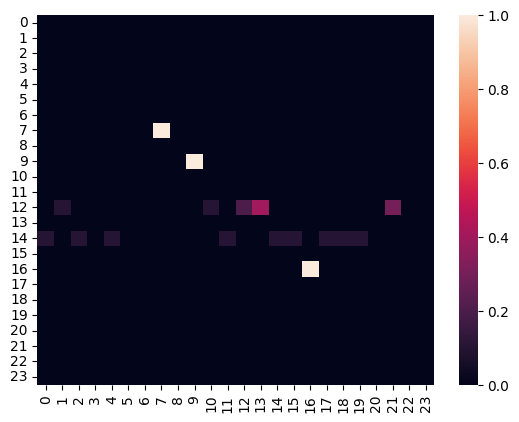

In [47]:
pd.set_option('display.max_columns', 25)
cm=pd.DataFrame(confusion_matrix(y.pred,y.true,normalize='true')).round(1)


import seaborn as sns
%matplotlib inline


#df = DataFrame(abs(np.random.randn(5, 4)), index=Index, columns=Cols)

sns.heatmap(cm, annot=False)

In [50]:
clf.predict("Hey, I'm really pissed. I need to cancel this order.  You guys screwed it up royally.")

[{'label': 'LABEL_17', 'score': 0.061517443507909775}]

In [55]:
labelDict

{'edit_account': 0,
 'switch_account': 1,
 'check_invoice': 2,
 'complaint': 3,
 'contact_customer_service': 4,
 'delivery_period': 5,
 'registration_problems': 6,
 'check_payment_methods': 7,
 'contact_human_agent': 8,
 'payment_issue': 9,
 'newsletter_subscription': 10,
 'get_invoice': 11,
 'place_order': 12,
 'cancel_order': 13,
 'track_refund': 14,
 'change_order': 15,
 'get_refund': 16,
 'create_account': 17,
 'check_refund_policy': 18,
 'review': 19,
 'set_up_shipping_address': 20,
 'delivery_options': 21,
 'delete_account': 22,
 'recover_password': 23,
 'track_order': 24,
 'change_shipping_address': 25,
 'check_cancellation_fee': 26}